## Problem Statement:

As a data scientist working for Harold Pike construction, I am interested in finding out which variables are the largest indicators of sale price. Harold Pike Construction renovates homes and builds homes from the ground up. If we can find out which attributes lead to highest sale price, we will have a better idea of where and what type of house to build/renovate to maximize our profits. Is location the leading factor driving Sale Price? Which type of house and how much land are ideal? Other than size of the house and location, what is one surprising trait that significantly increases house prices?

I will be presenting to the board on where/what type of houses need to be built/renovated to maximize our profits. 

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

In [363]:
# Read in Clean Data
df = pd.read_csv('datasets/train_clean.csv')

In [364]:
# First 5 rows of clean data
df.head()

Unnamed: 0   Id        PID  MS SubClass  Lot Frontage  Lot Area  \
0           0  109  533352170           60       69.0552     13517   
1           1  544  531379050           60       43.0000     11492   
2           2  153  535304180           20       68.0000      7922   
3           3  318  916386060           60       73.0000      9802   
4           4  255  906425045           50       82.0000     14235   

   Overall Qual  Overall Cond  Year Built  Year Remod/Add  ...  \
0             6             8        1976            2005  ...   
1             7             5        1996            1997  ...   
2             5             7        1953            2007  ...   
3             5             5        2006            2007  ...   
4             6             8        1900            1993  ...   

   Misc Feature_Shed  Misc Feature_TenC  Sale Type_CWD  Sale Type_Con  \
0                  0                  0              0              0   
1                  0                  0              0              0   
2                  0                  0              0              0   
3                  0                  0              0              0   
4                  0                  0              0              0   

   Sale Type_ConLD  Sale Type_ConLI  Sale Type_ConLw  Sale Type_New  \
0                0                0                0              0   
1                0                0                0              0   
2                0                0                0              0   
3                0                0                0              0   
4                0                0                0              0   

   Sale Type_Oth  Sale Type_WD   
0              0              1  
1              0              1  
2              0              1  
3              0              1  
4              0              1  

[5 rows x 266 columns]

In [367]:
# Drop ID and PID
df.drop(columns=['Id', 'PID'], inplace=True)

In [382]:
# Correlations in relation to Sale Price (My model used 65)
df.corr()['SalePrice']

Unnamed: 0         0.027789
MS SubClass       -0.087335
Lot Frontage       0.325850
Lot Area           0.296566
Overall Qual       0.800207
                     ...   
Sale Type_ConLw   -0.035479
Sale Type_New      0.358102
Sale Type_Oth     -0.030109
Sale Type_WD      -0.212542
fireplace_one      0.485858
Name: SalePrice, Length: 265, dtype: float64

In [383]:
# Positive Correlations sorted
df_corr_pos = df.corr()['SalePrice'].sort_values(ascending=False)

In [384]:
# First 20 positve correlations (my model used 65)
df_corr_pos[0:20]

SalePrice               1.000000
Overall Qual            0.800207
Gr Liv Area             0.697038
Garage Area             0.649897
Garage Cars             0.647781
Total Bsmt SF           0.629303
1st Flr SF              0.618486
Year Built              0.571849
Year Remod/Add          0.550370
Full Bath               0.537969
Foundation_PConc        0.529047
Garage Yr Blt           0.516738
Mas Vnr Area            0.508602
TotRms AbvGrd           0.504014
fireplace_one           0.485858
Fireplaces              0.471093
BsmtFin Type 1_GLQ      0.463549
Neighborhood_NridgHt    0.448647
Exter Qual_Gd           0.446685
BsmtFin SF 1            0.423856
Name: SalePrice, dtype: float64

In [385]:
# Negatively correlated features (my model also used 65)
df_corr_neg = df.corr()['SalePrice'].sort_values()

In [386]:
# First 15 negative correlated
df_corr_neg[0:15]

Exter Qual_TA               -0.600362
Kitchen Qual_TA             -0.540860
Fireplace Qu_No Fireplace   -0.485858
Bsmt Qual_TA                -0.456979
Garage Finish_Unf           -0.432220
Mas Vnr Type_None           -0.424088
Garage Type_Detchd          -0.370344
Foundation_CBlock           -0.355535
Heating QC_TA               -0.343542
Lot Shape_Reg               -0.306291
Bsmt Exposure_No            -0.293106
MS Zoning_RM                -0.281951
Roof Style_Gable            -0.249329
Garage Type_No Garage       -0.230990
Garage Cond_No Garage       -0.230855
Name: SalePrice, dtype: float64

## Experimentation with Visuals

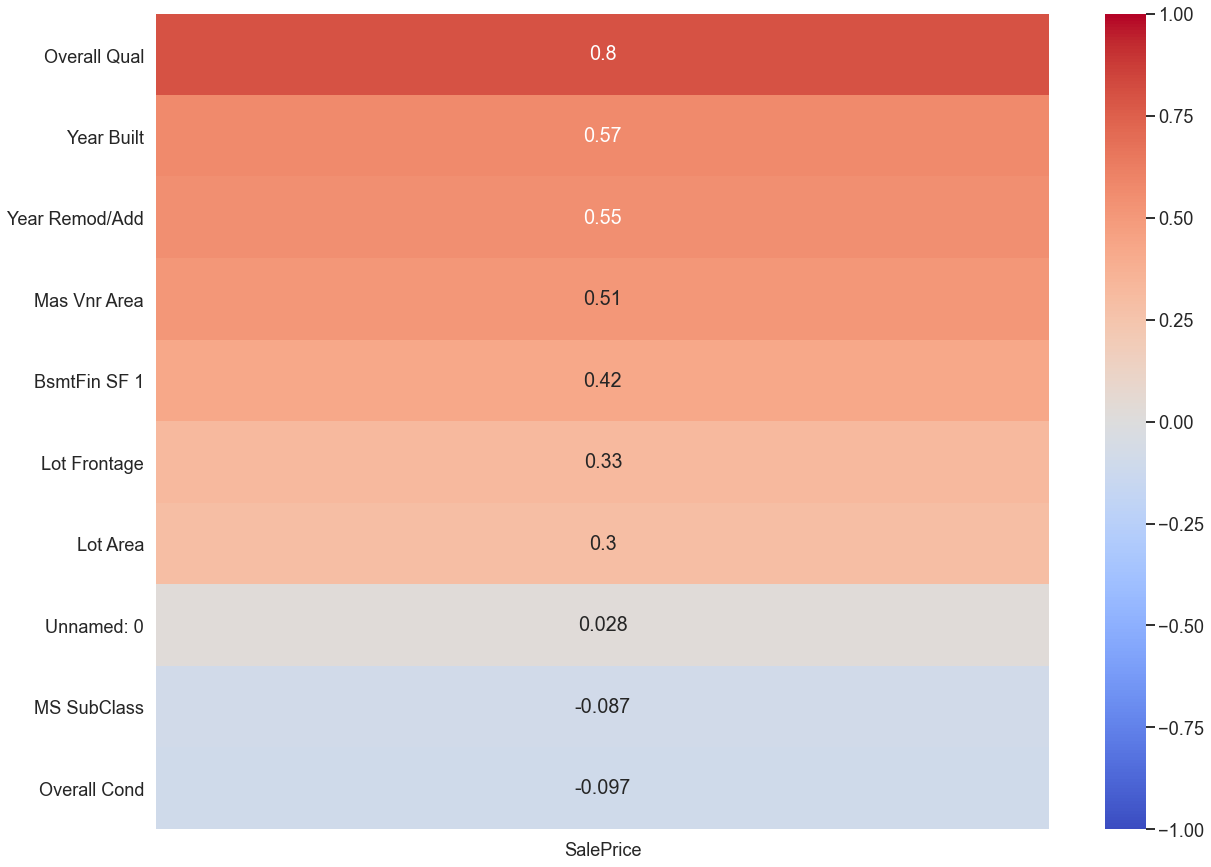

In [373]:
# Heatmap of the postive correlations top 10
sns.heatmap(df.corr()[['SalePrice']][0:10].sort_values(by=['SalePrice'],
                        ascending=False), vmin = -1, vmax=1, annot=True, cmap='coolwarm')

sns.set(rc={'figure.figsize':(20,15)})

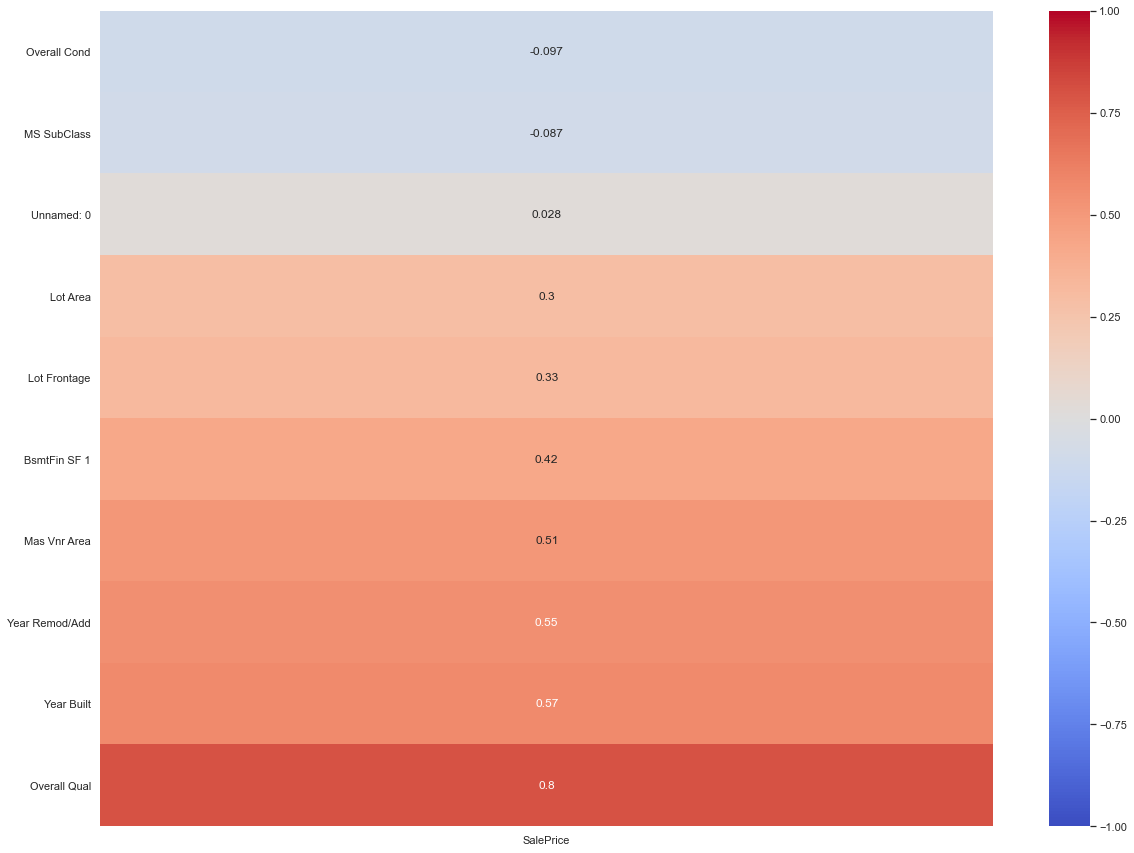

In [374]:
# Reverse heatmap correlations top 10 (Not particuarly useful)
sns.heatmap(df.corr()[['SalePrice']][0:10].sort_values(by=['SalePrice']),
            vmin = -1, vmax=1, annot=True, cmap='coolwarm')

sns.set(rc={'figure.figsize':(20,15)})

In [144]:
# I am interested in seeing the relationship with Fireplaces as it seems like something that could easily be changed
# if I was to renovate or build a house.

In [387]:
# Value Counts of fireplaces
df['Fireplaces'].value_counts()

0    1000
1     898
2     146
3       6
4       1
Name: Fireplaces, dtype: int64

In [388]:
# Change to text for visual
df['Fireplaces'].map({0: 'No Fireplace', 1: 'One Fireplace',2:'Two Fireplaces',
                        3:'Three Fireplaces', 4:'Four Fireplaces'})

0         No Fireplace
1        One Fireplace
2         No Fireplace
3         No Fireplace
4         No Fireplace
             ...      
2046     One Fireplace
2047      No Fireplace
2048     One Fireplace
2049    Two Fireplaces
2050     One Fireplace
Name: Fireplaces, Length: 2051, dtype: object

In [389]:
# Group according to houses that have 1 or more fireplace
df['fireplace_one'] = df['Fireplaces'] != 0

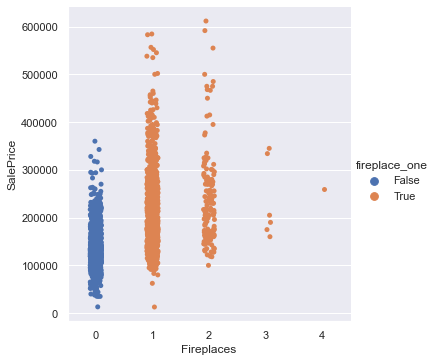

In [390]:
# Catplot of 0 fireplaces vs. multiple 
sns.catplot(x="Fireplaces", y="SalePrice", hue="fireplace_one", data=df);

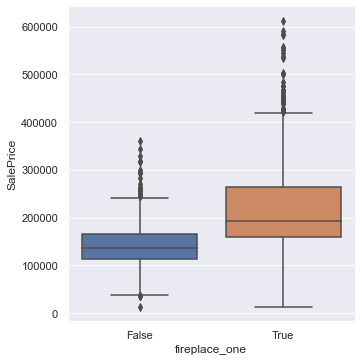

In [391]:
# Boxplot of 0 fireplaces vs. 1 or more fireplace
sns.catplot(x="fireplace_one", y="SalePrice", kind='box', data=data)

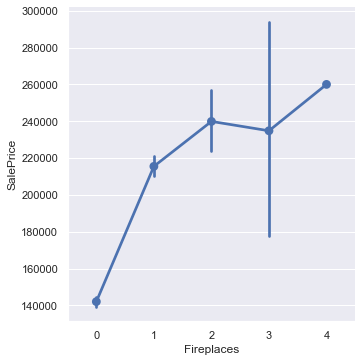

In [392]:
# Fireplace amounts vs. Average Sale Price (rough)
sns.catplot(x="Fireplaces", y="SalePrice", kind='point',data=data)

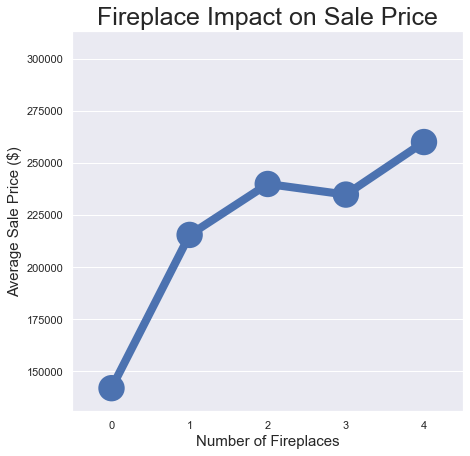

In [152]:
# Cleaned up fireplace impact on sale price point plot
# We see the largest jump from 0 fireplaces to 1 fireplace, suggesting that it is most important to have at least 1. 

fig = plt.figure(figsize=(7, 7))

fig = sns.pointplot(x="Fireplaces", y="SalePrice", data=data, 
              markers = 'o', errwidth=0, scale=3)
fig.set_xlabel('Number of Fireplaces', fontsize = 15)
fig.set_ylabel('Average Sale Price ($)', fontsize=15)
fig.set_title('Fireplace Impact on Sale Price', fontsize = 25);




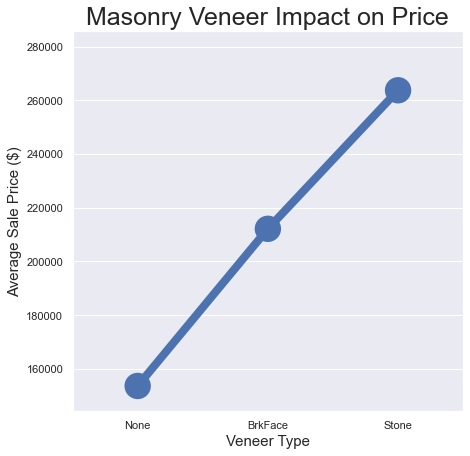

In [393]:
# Masonry Veneer impact on price
# We see that no masonry veneer has a much lower average sale price than brick or stone veneer.

fig = plt.figure(figsize=(7, 7))

fig = sns.pointplot(x="Mas Vnr Type", y="SalePrice", data=data, 
              markers = 'o', errwidth=0, scale=3, order=['None', 'BrkFace', 'Stone'])
fig.set_xlabel('Veneer Type', fontsize = 15)
fig.set_ylabel('Average Sale Price ($)', fontsize=15)
fig.set_title('Masonry Veneer Impact on Price', fontsize = 25);




In [394]:
# Examine the Garage feature as it was very negatively correlated when unfinished
data['Garage Finish'].value_counts()

Unf    849
RFn    579
Fin    509
Name: Garage Finish, dtype: int64

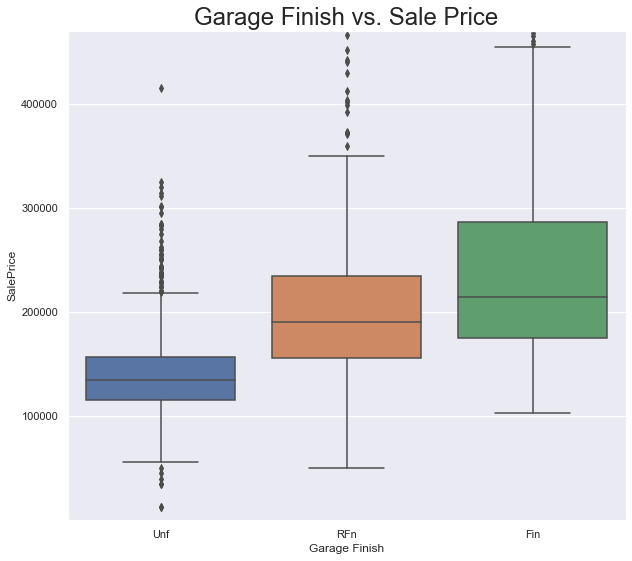

In [395]:
# Boxplot of garage finished vs. unfinished against sale price 
# We see that an unfinished garage has a much lower average sale price than rough finish or finished 

plt.figure(figsize=(10,9))
g = sns.boxplot(x="Garage Finish", y="SalePrice", data=data, order=['Unf', 'RFn', 'Fin'])
plt.ylim(10, 470000)
plt.title("Garage Finish vs. Sale Price", fontsize=24);


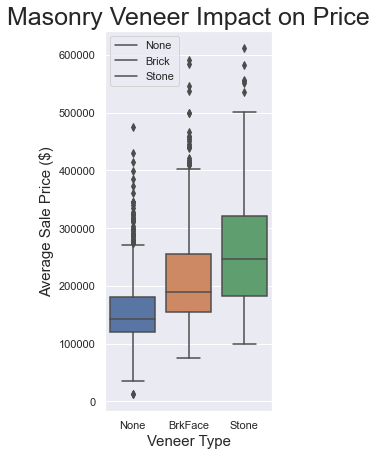

In [396]:
# Masonry Veneer boxplot against Price shows the same thing. No veneer leads to lower sale price

fig = plt.figure(figsize=(3, 7))
fig = sns.boxplot(x="Mas Vnr Type", y="SalePrice", data=data, order=['None', 'BrkFace', 'Stone'])

fig.set_xlabel('Veneer Type', fontsize = 15)
fig.set_ylabel('Average Sale Price ($)', fontsize=15)
fig.set_title('Masonry Veneer Impact on Price', fontsize = 25)
fig.legend(['None', 'Brick', 'Stone']);

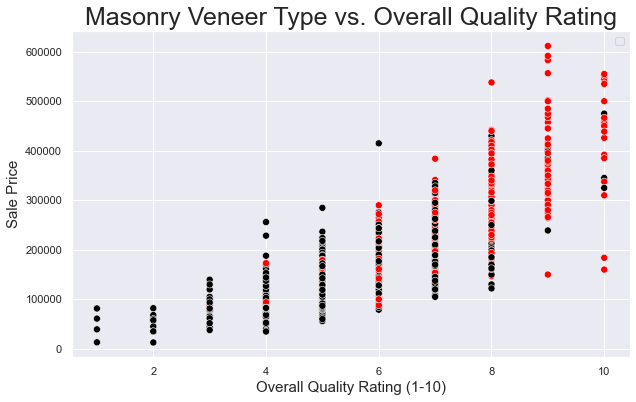

In [397]:
# Overall Quality vs. Sale Price grouped by Masonry Veneer Type.
# This chart is a great visual in that it shows that most houses with an overall quality have veneer.

plt.figure(figsize=(10,6))
g = sns.scatterplot(x="Overall Qual", 
                y="SalePrice", 
                hue="Mas Vnr Type",
                data=data,s=50, hue_order=['None','BrkFace','Stone','BrkCmn'],
                    palette=['black', 'red', 'red', 'red'])
plt.xlabel("Overall Quality Rating (1-10)", fontsize=15)
plt.ylabel("Sale Price", fontsize=15)
plt.title("Masonry Veneer Type vs. Overall Quality Rating", fontsize=25);

plt.legend([],[])



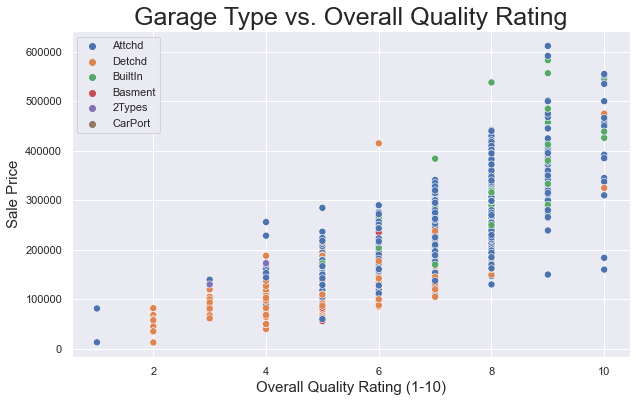

In [400]:
# Overall Quality vs. Sale Price grouped by Garage Type.
# Not the best visual but it is clear that the detached garages (orange) are generally in the left half
# of the graph (lower overall quality rating)

plt.figure(figsize=(10,6))
g = sns.scatterplot(x="Overall Qual", 
                y="SalePrice", 
                hue="Garage Type",
                data=data,s=50)
plt.xlabel("Overall Quality Rating (1-10)", fontsize=15)
plt.ylabel("Sale Price", fontsize=15)
plt.title("Garage Type vs. Overall Quality Rating", fontsize=25);

plt.legend()
